# Investigation of the Safford Flight

There are some oddities in the result given by Markus, especially along the boundary between flight 144152 (west) and 170526 (east).
This investigation is to see if there is any indication in the raw data why this discrepancy may exist.
It should be noted that the flights occurred 7 days apart, 144152 on September 9, 2023 and 1705226 on September 1, 2023.

In [2]:
# imports

import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scygnal
import scipy
import matplotlib.colors as mcolors
from vqf import offlineVQF, VQF
from copy import deepcopy
import utm
import bagpy
import logging
import pandas as pd
import datetime
import pyIGRF
from dateutil.parser import parse
from typing import Union, Tuple  # Dict
from PyQt5.QtWidgets import QApplication
from numba_progress import ProgressBar
import os
import pytz
import re
import quaternion as q_lib_external

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

Text(0.5, 1.0, 'GPS Path for Compared Flights')

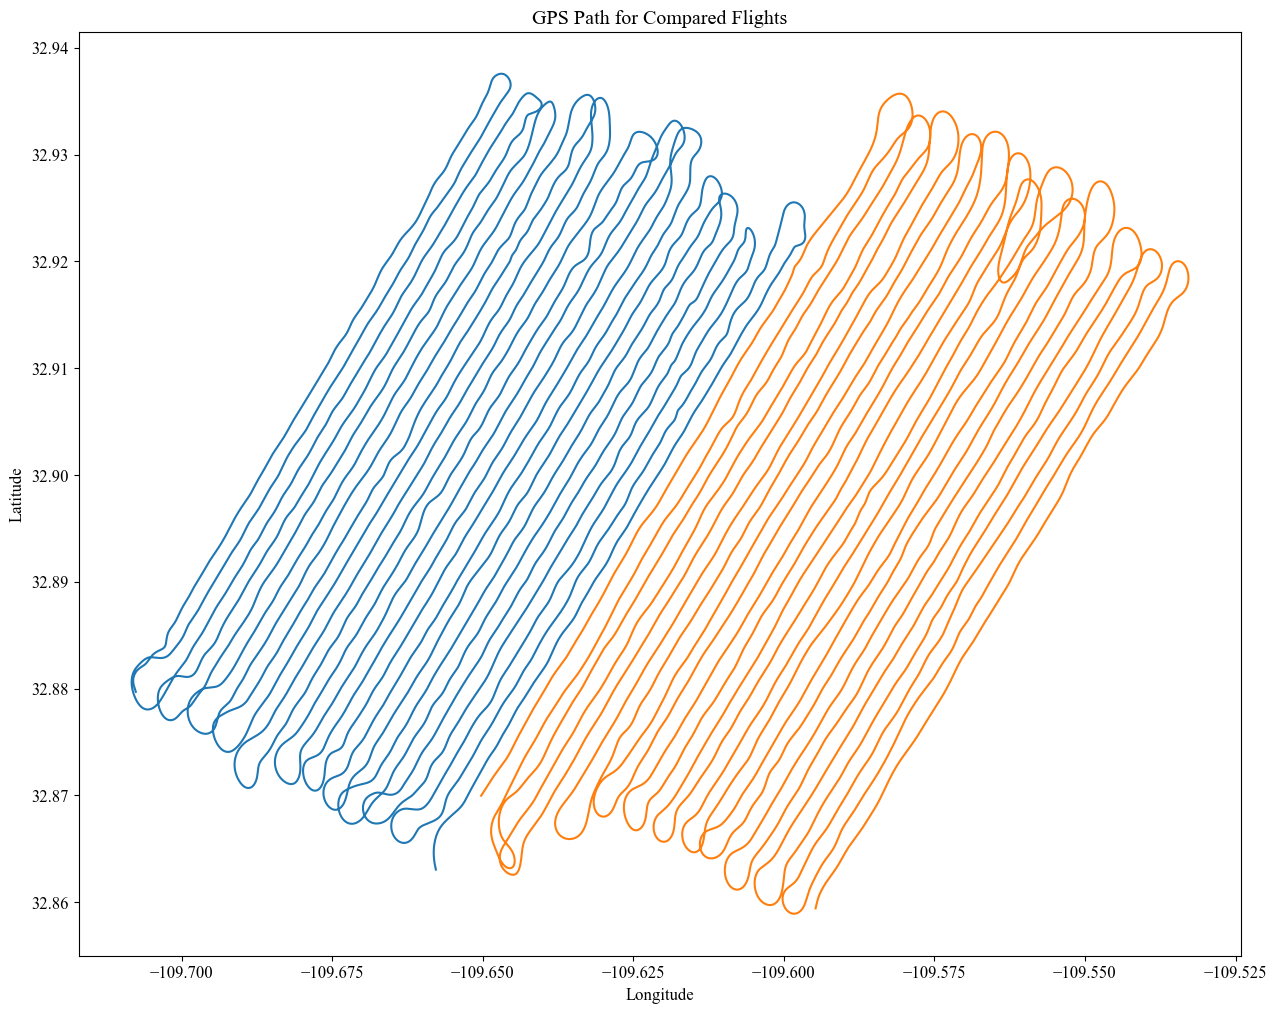

In [3]:
# load GPS data

lat_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\gps_lat.npy')
lon_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\gps_lon.npy')

lat_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\gps_lat.npy')
lon_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\gps_lon.npy')

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:, :])
ax.plot(lon_east, lat_east, label='170526')
ax.plot(lon_west, lat_west, label='144152')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GPS Path for Compared Flights')

Both flights start on the left heading North East, then come back South West, ending on the right hand side.
The differing flights will be concatentated together to see if there are any obvious issues with the uimu (accelerometers, gyroscopes, fluxgate) or with the SQUID data.

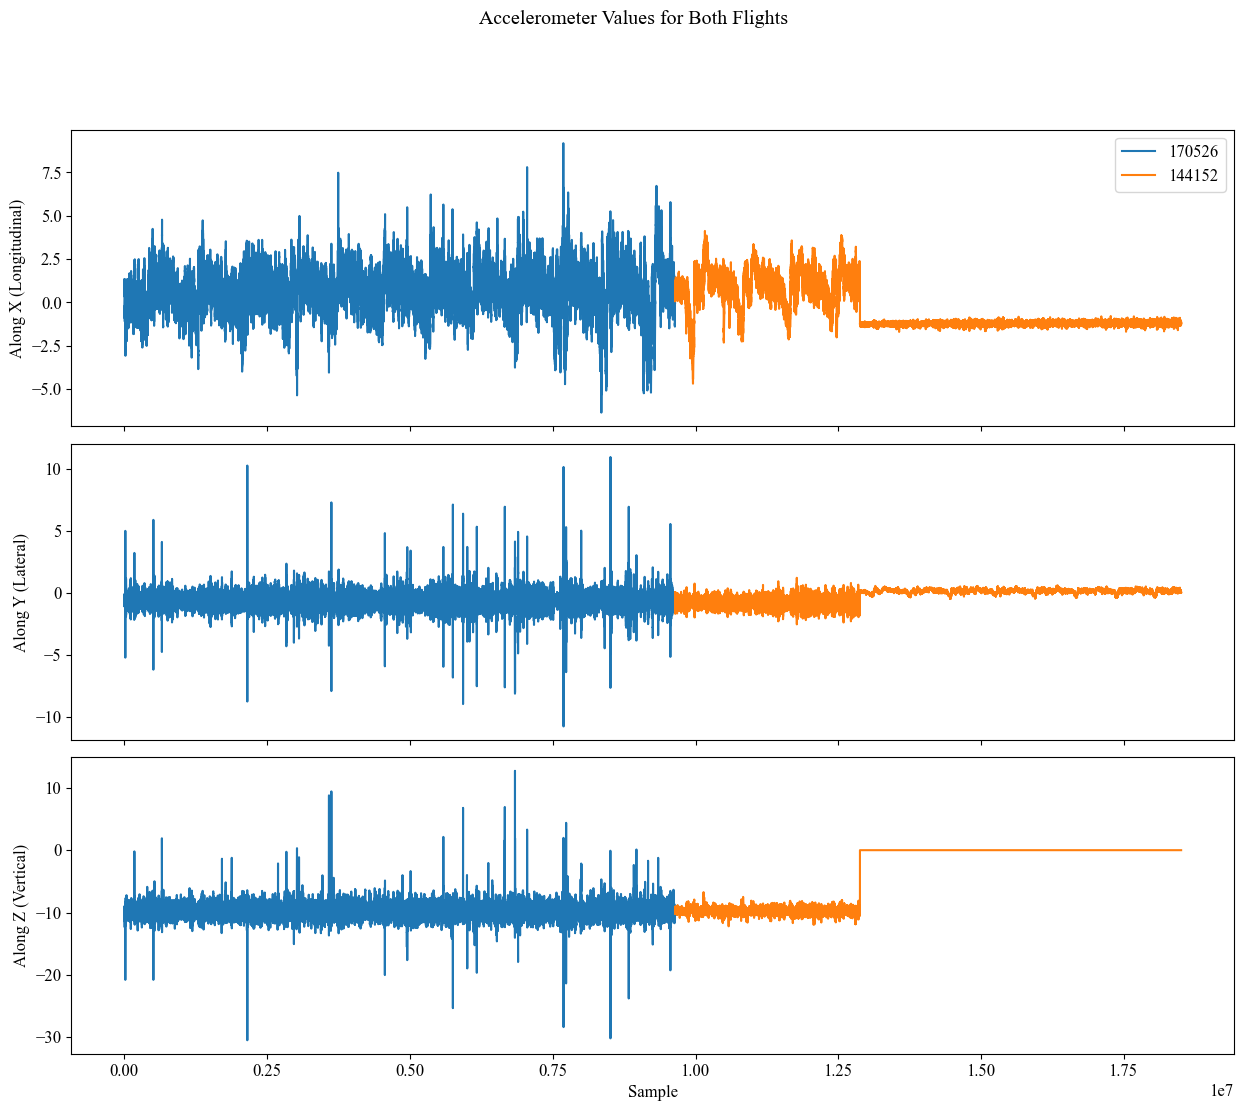

In [13]:
# uimu acc check
uimu_acc_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\uimu_acc.npy')
uimu_gyro_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\uimu_gyro.npy')
uimu_flux_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\uimu_mag.npy')
uimu_start_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\flight_start_imu.npy')
uimu_end_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\flight_end_imu.npy')

uimu_acc_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\uimu_acc.npy')
uimu_gyro_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\uimu_gyro.npy')
uimu_flux_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\uimu_mag.npy')
uimu_start_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\flight_start_imu.npy')
uimu_end_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\flight_end_imu.npy')

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
ax1.plot(np.arange(len(uimu_acc_east[uimu_start_east:uimu_end_east, 0])), 
         uimu_acc_east[uimu_start_east:uimu_end_east, 0], label='170526')
ax1.plot(np.arange(len(uimu_acc_east[uimu_start_east:uimu_end_east, 0]), 
                   len(uimu_acc_east[uimu_start_east:uimu_end_east, 0]) + len(uimu_acc_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_acc_west[uimu_start_west:uimu_end_west, 0], label='144152')
ax1.tick_params(labelbottom=False)
ax1.set_ylabel('Along X (Longitudinal)')
ax2.plot(np.arange(len(uimu_acc_east[uimu_start_east:uimu_end_east, 1])), 
         uimu_acc_east[uimu_start_east:uimu_end_east, 1], label='170526')
ax2.plot(np.arange(len(uimu_acc_east[uimu_start_east:uimu_end_east, 1]), 
                   len(uimu_acc_east[uimu_start_east:uimu_end_east, 1]) + len(uimu_acc_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_acc_west[uimu_start_west:uimu_end_west, 1], label='144152')
ax2.tick_params(labelbottom=False)
ax2.set_ylabel('Along Y (Lateral)')
ax3.plot(np.arange(len(uimu_acc_east[uimu_start_east:uimu_end_east, 2])), 
         uimu_acc_east[uimu_start_east:uimu_end_east, 2], label='170526')
ax3.plot(np.arange(len(uimu_acc_east[uimu_start_east:uimu_end_east, 2]), 
                   len(uimu_acc_east[uimu_start_east:uimu_end_east, 2]) + len(uimu_acc_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_acc_west[uimu_start_west:uimu_end_west, 2], label='144152')
ax3.set_ylabel('Along Z (Vertical)')
ax3.set_xlabel('Sample')

fig.suptitle('Accelerometer Values for Both Flights')
ax1.legend(loc='upper right')

It appears that there is an issue with the uimu data in the 144152 flight.
When concatentated together, the two look similar except maybe less noise on flight 144152.

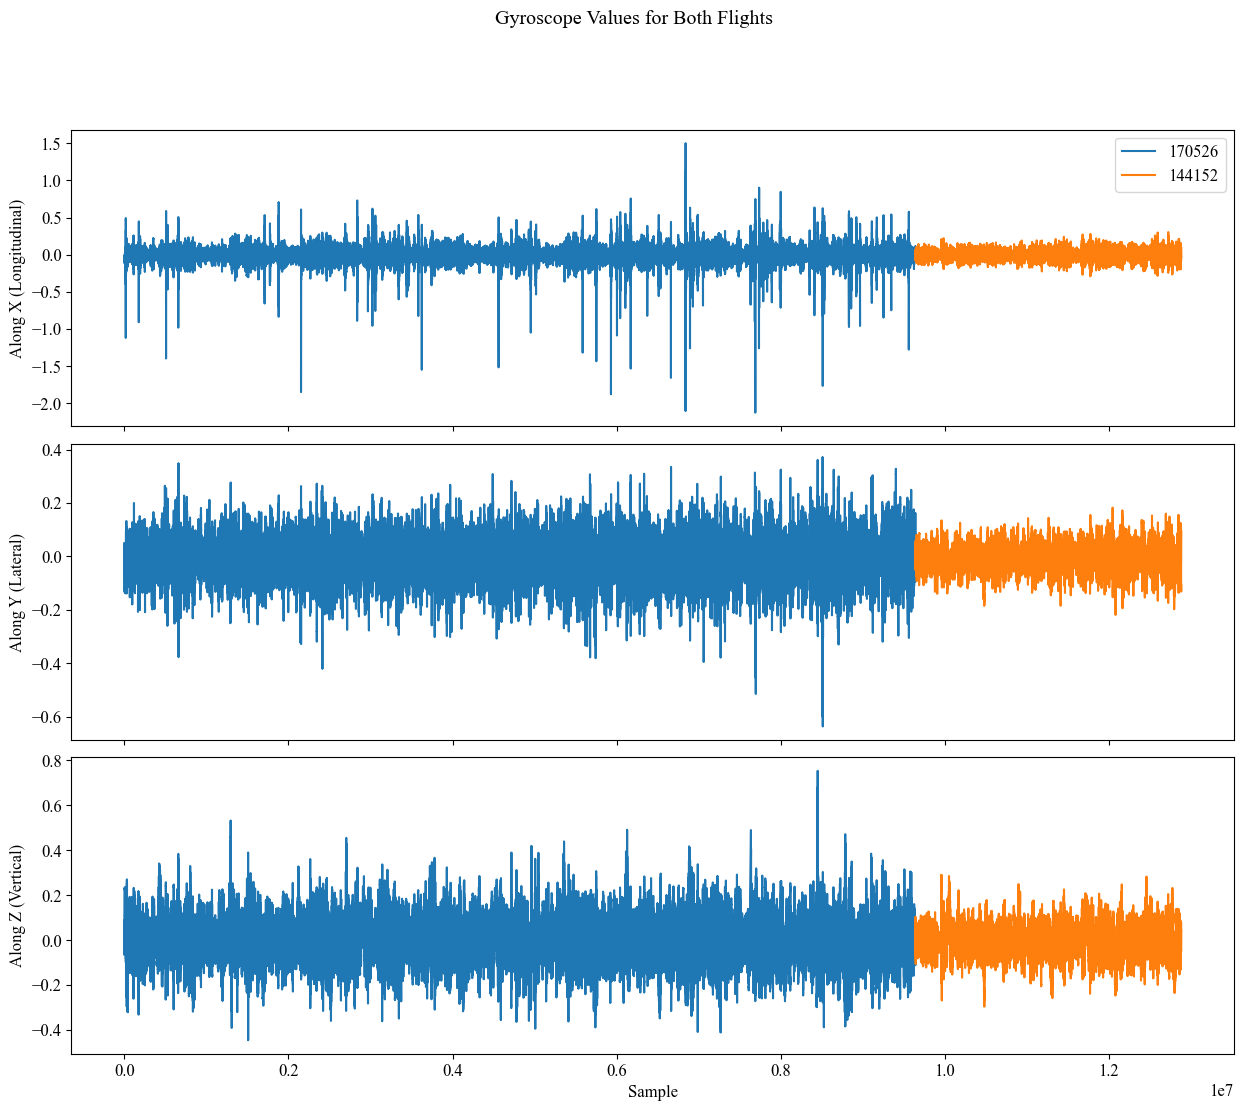

In [14]:
# uimu gyro check

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
ax1.plot(np.arange(len(uimu_gyro_east[uimu_start_east:uimu_end_east, 0])), 
         uimu_gyro_east[uimu_start_east:uimu_end_east, 0], label='170526')
ax1.plot(np.arange(len(uimu_gyro_east[uimu_start_east:uimu_end_east, 0]), 
                   len(uimu_gyro_east[uimu_start_east:uimu_end_east, 0]) + len(uimu_gyro_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_gyro_west[uimu_start_west:uimu_end_west, 0], label='144152')
ax1.tick_params(labelbottom=False)
ax1.set_ylabel('Along X (Longitudinal)')
ax2.plot(np.arange(len(uimu_gyro_east[uimu_start_east:uimu_end_east, 1])), 
         uimu_gyro_east[uimu_start_east:uimu_end_east, 1], label='170526')
ax2.plot(np.arange(len(uimu_gyro_east[uimu_start_east:uimu_end_east, 1]), 
                   len(uimu_gyro_east[uimu_start_east:uimu_end_east, 1]) + len(uimu_gyro_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_gyro_west[uimu_start_west:uimu_end_west, 1], label='144152')
ax2.tick_params(labelbottom=False)
ax2.set_ylabel('Along Y (Lateral)')
ax3.plot(np.arange(len(uimu_gyro_east[uimu_start_east:uimu_end_east, 2])), 
         uimu_gyro_east[uimu_start_east:uimu_end_east, 2], label='170526')
ax3.plot(np.arange(len(uimu_gyro_east[uimu_start_east:uimu_end_east, 2]), 
                   len(uimu_gyro_east[uimu_start_east:uimu_end_east, 2]) + len(uimu_gyro_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_gyro_west[uimu_start_west:uimu_end_west, 2], label='144152')
ax3.set_ylabel('Along Z (Vertical)')
ax3.set_xlabel('Sample')

fig.suptitle('Gyroscope Values for Both Flights')
ax1.legend(loc='upper right')

Whatever the issue with the data cutoff on the accelerometer was, it leads to NaNs on the gyroscope, so it doesn't plot the full sample range.
No obvious difference except perhaps less noise.

In [ ]:
# uimu fluxgate check

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
ax1.plot(np.arange(len(uimu_flux_east[uimu_start_east:uimu_end_east, 0])), 
         uimu_flux_east[uimu_start_east:uimu_end_east, 0], label='170526')
ax1.plot(np.arange(len(uimu_flux_east[uimu_start_east:uimu_end_east, 0]), 
                   len(uimu_flux_east[uimu_start_east:uimu_end_east, 0]) + len(uimu_flux_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_flux_west[uimu_start_west:uimu_end_west, 0], label='144152')
ax1.tick_params(labelbottom=False)
ax1.set_ylabel('Along X (Longitudinal)')
ax2.plot(np.arange(len(uimu_flux_east[uimu_start_east:uimu_end_east, 1])), 
         uimu_flux_east[uimu_start_east:uimu_end_east, 1], label='170526')
ax2.plot(np.arange(len(uimu_flux_east[uimu_start_east:uimu_end_east, 1]), 
                   len(uimu_flux_east[uimu_start_east:uimu_end_east, 1]) + len(uimu_flux_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_flux_west[uimu_start_west:uimu_end_west, 1], label='144152')
ax2.tick_params(labelbottom=False)
ax2.set_ylabel('Along Y (Lateral)')
ax3.plot(np.arange(len(uimu_flux_east[uimu_start_east:uimu_end_east, 2])), 
         uimu_flux_east[uimu_start_east:uimu_end_east, 2], label='170526')
ax3.plot(np.arange(len(uimu_flux_east[uimu_start_east:uimu_end_east, 2]), 
                   len(uimu_flux_east[uimu_start_east:uimu_end_east, 2]) + len(uimu_flux_west[uimu_start_west:uimu_end_west, 0])), 
         uimu_flux_west[uimu_start_west:uimu_end_west, 2], label='144152')
ax3.set_ylabel('Along Z (Vertical)')
ax3.set_xlabel('Sample')

fig.suptitle('Fluxgate Values for Both Flights')
ax1.legend(loc='upper right')

The fluxgate was determined to have issues for this set of flights, and offer no real insight.

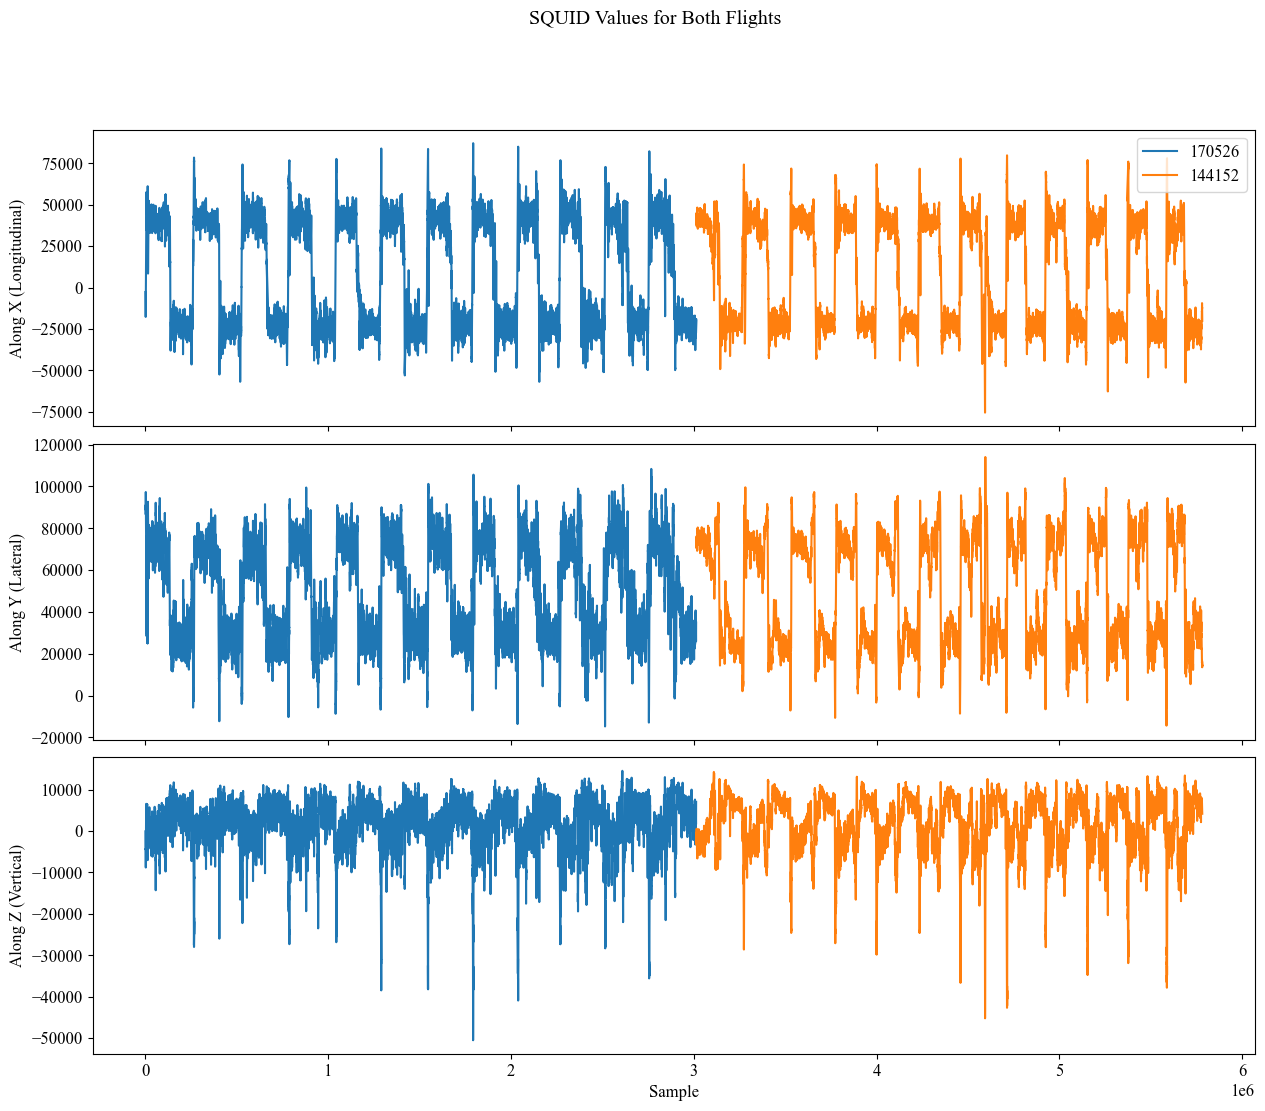

In [18]:
# SQUID data check

squid_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\full_squid.npy')
squid_start_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\flight_start_squid.npy')
squid_end_east = np.load(r'D:\Field_Data\Safford_comparisons\170526\flight_end_squid.npy')

squid_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\full_squid.npy')
squid_start_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\flight_start_squid.npy')
squid_end_west = np.load(r'D:\Field_Data\Safford_comparisons\144152\flight_end_squid.npy')

fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
ax1.plot(np.arange(len(squid_east[squid_start_east:squid_end_east:100, 0])), 
         squid_east[squid_start_east:squid_end_east:100, 0], label='170526')
ax1.plot(np.arange(len(squid_east[squid_start_east:squid_end_east:100, 0]), 
                   len(squid_east[squid_start_east:squid_end_east:100, 0]) + len(squid_west[squid_start_west:squid_end_west:100, 0])), 
         squid_west[squid_start_west:squid_end_west:100, 0], label='144152')
ax1.tick_params(labelbottom=False)
ax1.set_ylabel('Along X (Longitudinal)')
ax2.plot(np.arange(len(squid_east[squid_start_east:squid_end_east:100, 1])), 
         squid_east[squid_start_east:squid_end_east:100, 1], label='170526')
ax2.plot(np.arange(len(squid_east[squid_start_east:squid_end_east:100, 1]), 
                   len(squid_east[squid_start_east:squid_end_east:100, 1]) + len(squid_west[squid_start_west:squid_end_west:100, 0])), 
         squid_west[squid_start_west:squid_end_west:100, 1], label='144152')
ax2.tick_params(labelbottom=False)
ax2.set_ylabel('Along Y (Lateral)')
ax3.plot(np.arange(len(squid_east[squid_start_east:squid_end_east:100, 2])), 
         squid_east[squid_start_east:squid_end_east:100, 2], label='170526')
ax3.plot(np.arange(len(squid_east[squid_start_east:squid_end_east:100, 2]), 
                   len(squid_east[squid_start_east:squid_end_east:100, 2]) + len(squid_west[squid_start_west:squid_end_west:100, 0])), 
         squid_west[squid_start_west:squid_end_west:100, 2], label='144152')
ax3.set_ylabel('Along Z (Vertical)')
ax3.set_xlabel('Sample')

fig.suptitle('SQUID Values for Both Flights')
ax1.legend(loc='upper right')

The SQUID data also appears to be fairly consistent along the boundary in terms of trend.
Since our raw data offers nothing, I will move on to the time series provided by Markus.
It also seems strange that this would be the case that the raw SQUID data lines up so nicely, as each sensor should theoretically have a different offset every time it initializes.

In [37]:
import mat73

flight_170526_1 = mat73.loadmat(r"D:\Field_Data\Safford_comparisons\Markus\TS\20230901_170526_1.mat")
flight_170526_2 = mat73.loadmat(r"D:\Field_Data\Safford_comparisons\Markus\TS\20230901_170526_2_merged.mat")
flight_144152 = mat73.loadmat(r"D:\Field_Data\Safford_comparisons\Markus\TS\20230908_144152.mat")


Text(0.5, 1.0, 'GPS Path from Markus for Safford Flights')

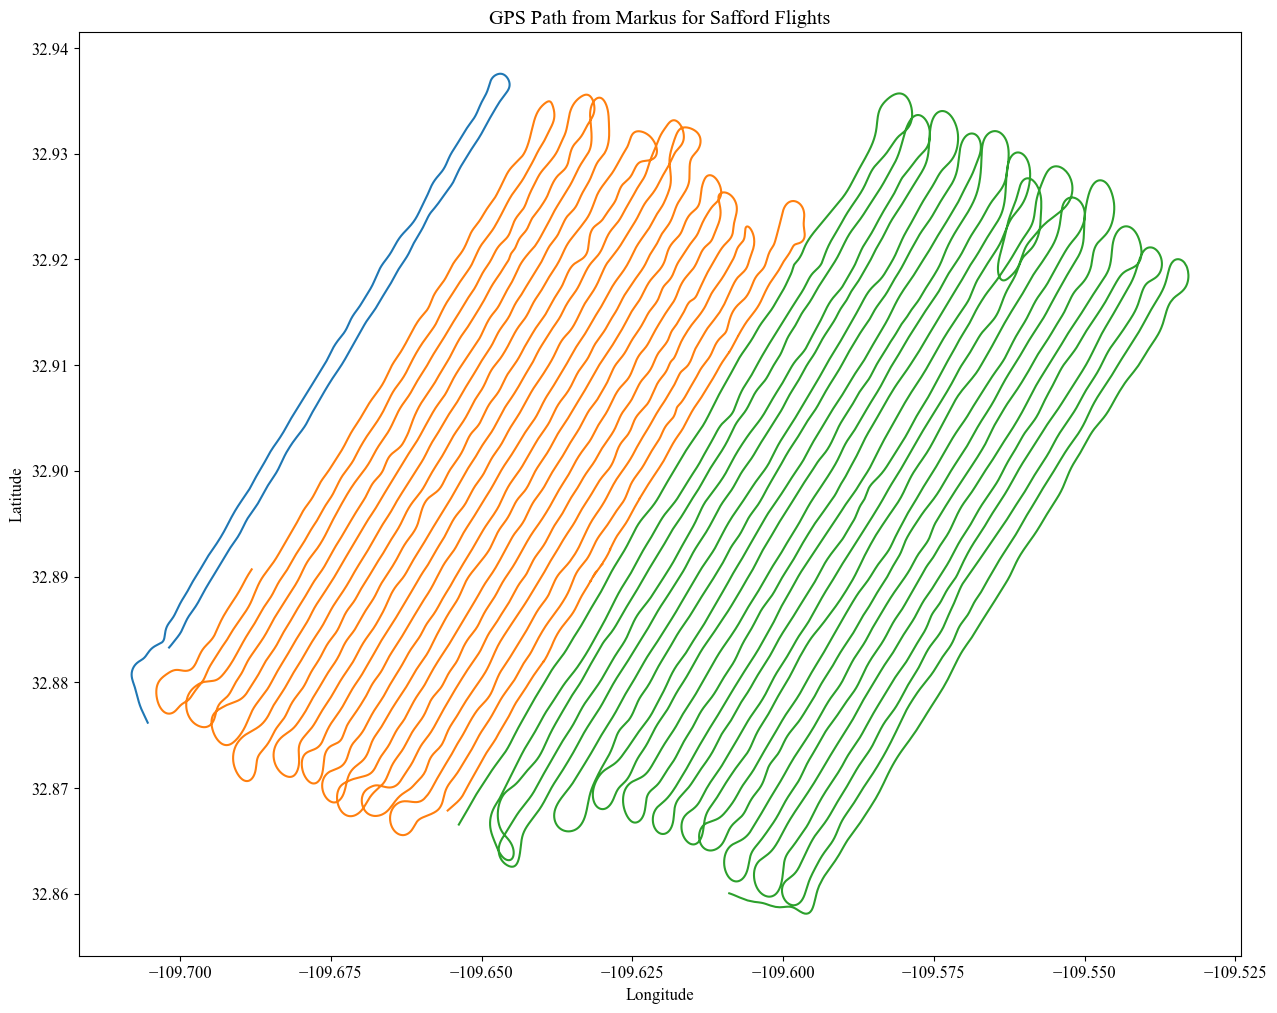

In [34]:
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax = fig.add_subplot(gs[:, :])
ax.plot(flight_170526_1['lon'][70000:], flight_170526_1['lat'][70000:], label='170526_1')
ax.plot(flight_170526_2['lon'][:-140000], flight_170526_2['lat'][:-140000], label='170526_2')
ax.plot(flight_144152['lon'][35000:-110000], flight_144152['lat'][35000:-110000], label='144152')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GPS Path from Markus for Safford Flights')

I'm not certain why, but Markus' results for the 170526 flight is split in two, and it appears as though we lost a line or two as a result?

In [35]:
markus_144152_start = np.argmin(np.abs(flight_144152['t'][35000] - flight_144152['ts']))
markus_144152_end = np.argmin(np.abs(flight_144152['t'][-110000] - flight_144152['ts']))
markus_170526_1_start = np.argmin(np.abs(flight_170526_1['t'][70000] - flight_170526_1['ts']))
markus_170526_1_end = np.argmin(np.abs(flight_170526_1['t'][-1] - flight_170526_1['ts']))
markus_170526_2_start = np.argmin(np.abs(flight_170526_2['t'][0] - flight_170526_2['ts']))
markus_170526_2_end = np.argmin(np.abs(flight_170526_2['t'][-140000] - flight_170526_2['ts']))

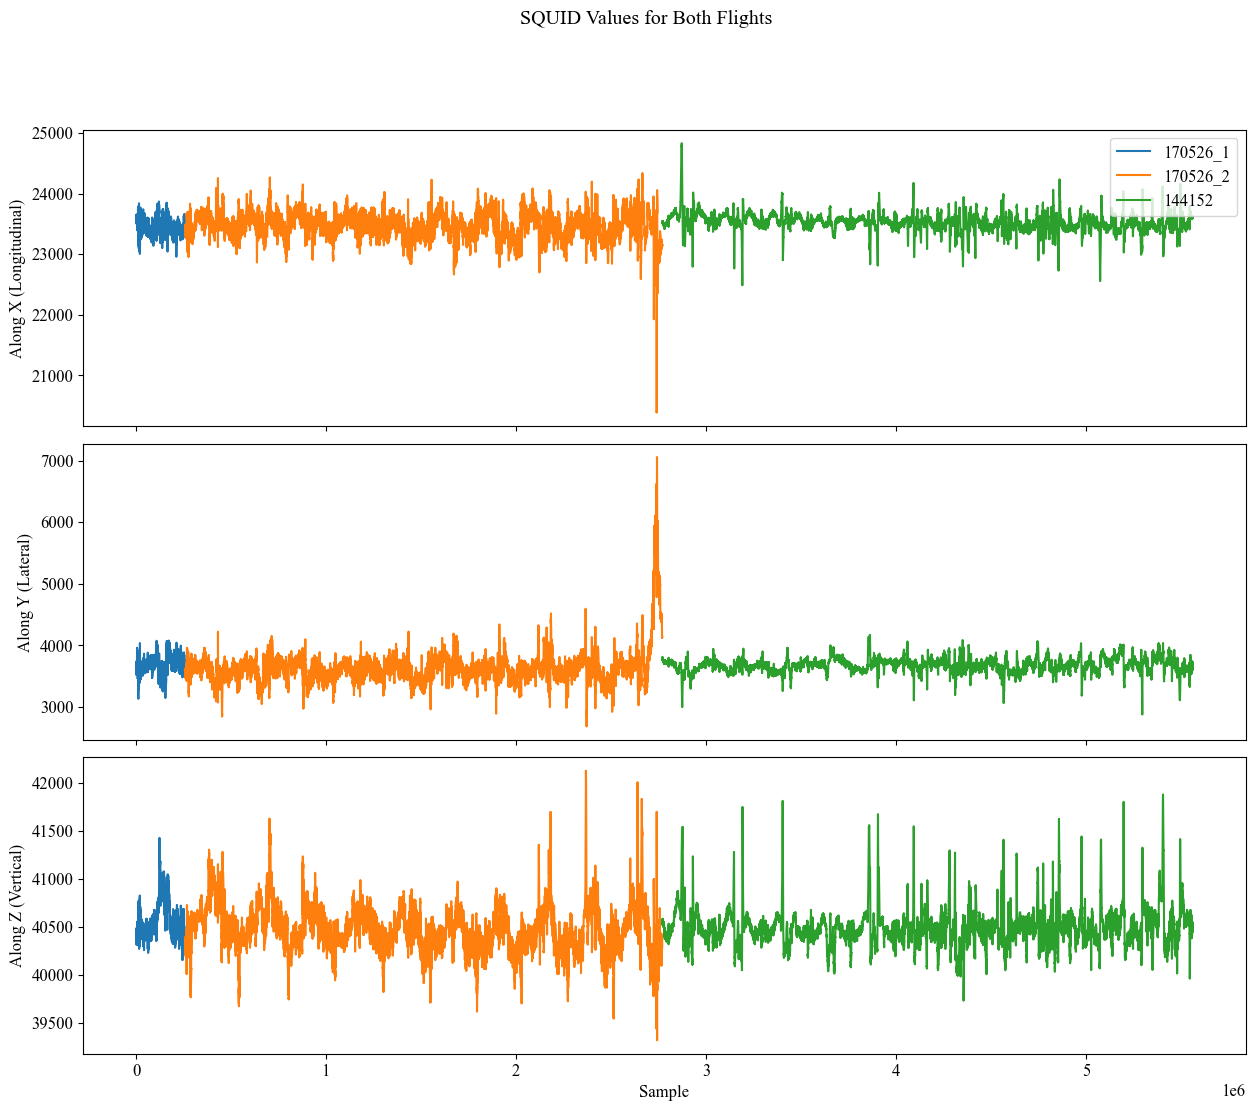

In [36]:
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(9, 9)
ax1 = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
ax1.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 0])), 
         flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 0], label='170526_1')
ax1.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 0]),
                   len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 0]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 0])), 
         flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 0], label='170526_2')
ax1.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 0]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 0]),
                   len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 0]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 0]) + 
                   len(flight_144152['B_bird'][markus_144152_start:markus_144152_end:100, 0])), 
         flight_144152['B_bird'][markus_144152_start:markus_144152_end:100, 0], label='144152')
ax1.tick_params(labelbottom=False)
ax1.set_ylabel('Along X (Longitudinal)')
ax2.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 1])), 
         flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 1], label='170526_1')
ax2.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 1]),
                   len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 1]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 1])), 
         flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 1], label='170526_2')
ax2.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 1]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 1]),
                   len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 1]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 1]) + 
                   len(flight_144152['B_bird'][markus_144152_start:markus_144152_end:100, 1])), 
         flight_144152['B_bird'][markus_144152_start:markus_144152_end:100, 1], label='144152')
ax2.tick_params(labelbottom=False)
ax2.set_ylabel('Along Y (Lateral)')
ax3.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 2])), 
         flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 2], label='170526_1')
ax3.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 2]),
                   len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 2]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 2])), 
         flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 2], label='170526_2')
ax3.plot(np.arange(len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 2]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 2]),
                   len(flight_170526_1['B_bird'][markus_170526_1_start:markus_170526_1_end:100, 2]) + 
                   len(flight_170526_2['B_bird'][markus_170526_2_start:markus_170526_2_end:100, 2]) + 
                   len(flight_144152['B_bird'][markus_144152_start:markus_144152_end:100, 2])), 
         flight_144152['B_bird'][markus_144152_start:markus_144152_end:100, 2], label='144152')
ax3.set_ylabel('Along Z (Vertical)')
ax3.set_xlabel('Sample')

fig.suptitle('SQUID Values for Both Flights')
ax1.legend(loc='upper right')

From this view, it appears that the 144152 flight has less noise.
The cause of the large difference seen in Hormoz's plot of the transfer function does not appear obvious from this view.